In [ ]:
# Run CPU-only, GPU code needs further testing
"""
Restart kernel after running
Only need to run once
"""
!pip install scikit-learn matplotlib seaborn

In [1]:
# hardcode if not using UGE environment
import os
num_cores_uge = os.environ.get('NSLOTS')
print(num_cores_uge)

num_workers = 7

7


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import torch
import torch.utils.data as td
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset


froot = './data/k562_samp_epft_norm_test_1.csv'

df = pd.read_csv(froot)

/grid/it/data/elzar/easybuild/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3098: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(df.head())

  seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0       15  88623545  88623545      +  ENSG00000181026    0.0 -0.079992   
1       15  88623546  88623546      +  ENSG00000181026    0.0 -0.079942   
2       15  88623547  88623547      +  ENSG00000181026    0.0 -0.079893   
3       15  88623548  88623548      +  ENSG00000181026    0.0 -0.079844   
4       15  88623549  88623549      +  ENSG00000181026    0.0 -0.079796   

   h3k36me3   h3k4me1  h3k79me2   h3k9me1   h3k9me3  h4k20me1       sj5  \
0 -0.000099  0.348531  4.423451  0.446508 -0.168099  3.232475 -0.028916   
1  0.001638  0.352677  4.460072  0.453024 -0.169218  3.259194 -0.028916   
2  0.003360  0.356807  4.496664  0.459491 -0.170339  3.285849 -0.028916   
3  0.005065  0.360919  4.533223  0.465908 -0.171461  3.312435 -0.028916   
4  0.006754  0.365013  4.569743  0.472274 -0.172584  3.338952 -0.028916   

        sj3       dms  wgbs      rpts  lambda_alphaj      zeta  
0 -0.057178 -0.307549   0.0  0.24

In [4]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]
num_features = len(feature_names)
#nucleotides = column_names[-6:-2]
print(feature_names)
#print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['ctcf' 'h3k36me3' 'h3k4me1' 'h3k79me2' 'h3k9me1' 'h3k9me3' 'h4k20me1'
 'sj5' 'sj3' 'dms' 'wgbs' 'rpts']


In [5]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 16182613


In [6]:
print("Number of Features: " + str(num_features))

Number of Features: 12


In [7]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values

In [8]:
from sklearn.preprocessing import StandardScaler

"""
scaler = StandardScaler()
column_name = df.columns[-2]
df.iloc[:, -2] = scaler.fit_transform(df.iloc[:, -2].values.reshape(-1, 1))
"""

'\nscaler = StandardScaler()\ncolumn_name = df.columns[-2]\ndf.iloc[:, -2] = scaler.fit_transform(df.iloc[:, -2].values.reshape(-1, 1))\n'

In [9]:
C_j = df['lambda_alphaj'].values

In [10]:
gene_ids = df['ensembl_gene_id'].values

In [11]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: True
Number of GPUs available: 1


In [12]:
class CustomDataset(Dataset):
    def __init__(self, GeneId, Y_ji, X_ji, C_j, Z_ji):
        self.GeneId = GeneId
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji
        self.cache = {}  

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        data = {
            'GeneId':  self.GeneId[idx],
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float64),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float64),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float64),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float64)
        }
        self.cache[idx] = data
        return data

In [13]:
from sklearn.model_selection import GroupShuffleSplit

dataset = CustomDataset(gene_ids, Y_ji, X_ji, C_j, Z_ji)

# Convert gene IDs to numeric labels for GroupShuffleSplit
unique_genes = np.unique(gene_ids)
gene_to_idx = {gene: idx for idx, gene in enumerate(unique_genes)}
group_labels = np.array([gene_to_idx[gene] for gene in gene_ids])

gss_initial = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(gss_initial.split(np.zeros(len(group_labels)), groups=group_labels))

train_val_mask = np.zeros(len(group_labels), dtype=bool)
train_val_mask[train_val_idx] = True

train_val_groups = group_labels[train_val_mask]

gss_final = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx_rel, val_idx_rel = next(gss_final.split(np.zeros(len(train_val_idx)), groups=train_val_groups))

train_idx = train_val_idx[train_idx_rel]
val_idx = train_val_idx[val_idx_rel]

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

batch_size = 64

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1, bias=False)

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((64,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

model.double()

Linear(in_features=12, out_features=1, bias=False)
torch.Size([64, 1])
Number of parameters: 12
Model is on device: cuda:0


Linear(in_features=12, out_features=1, bias=False)

In [15]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, rho_ji):
        #print(rho_ji.shape)
        epsilon = 1e-8
        loss = X_ji * rho_ji + C_j * torch.exp(-rho_ji) - X_ji * torch.log(C_j)
        return (loss).mean()

In [16]:
# GPU testing with larger datasets
"""
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

def print_profiler_results(profiler):
    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),
    on_trace_ready=print_profiler_results,
    record_shapes=True,
    profile_memory=True
) as profiler:

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        model.train()
        trndl = DataLoader(train_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
        for i, batch in enumerate(trndl):
            optimizer.zero_grad()
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            profiler.step()
        loss_hist_train[epoch] /= len(trndl)
        del trndl

    model.eval()
    valdl = DataLoader(val_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')
"""

'\noptimizer = optim.Adam(model.parameters(), lr=0.0001)\n\nnum_epochs = 10\n\nloss_hist_train = [0] * num_epochs\nloss_hist_valid = [0] * num_epochs\n\nloss_fn = CustomLoss()\n\ndef print_profiler_results(profiler):\n    print(profiler.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))\n\nwith torch.profiler.profile(\n    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],\n    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3),\n    on_trace_ready=print_profiler_results,\n    record_shapes=True,\n    profile_memory=True\n) as profiler:\n\n    for epoch in range(num_epochs):\n        print(f\'Epoch {epoch+1}\')\n        model.train()\n        trndl = DataLoader(train_set, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)\n        for i, batch in enumerate(trndl):\n            optimizer.zero_grad()\n            Y_ji_batch = batch[\'Y_ji\'].to(device)\n            X_ji_batch = batch[\'X_ji\'].to(device)\n 

In [17]:
with torch.no_grad():
    for param in model.parameters():
        param.zero_()

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0)

num_epochs = 5

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(train_set, num_workers=num_workers, batch_size=batch_size, shuffle=False, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl

    model.eval()
    valdl = DataLoader(val_set, num_workers=num_workers, batch_size=batch_size, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')


Epoch 1
Epoch 1 trn_loss: 0.0934 val_loss: 0.0890
Epoch 2
Epoch 2 trn_loss: 0.0932 val_loss: 0.0890
Epoch 3
Epoch 3 trn_loss: 0.0932 val_loss: 0.0890
Epoch 4
Epoch 4 trn_loss: 0.0932 val_loss: 0.0890
Epoch 5
Epoch 5 trn_loss: 0.0932 val_loss: 0.0890


In [19]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Model_Large.pth"#_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [19]:

model = nn.Linear(num_features, 1)
model.load_state_dict(torch.load("models/Elongation_Model_chr16.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)


'\nmodel = nn.Linear(num_features, 1)\nmodel.load_state_dict(torch.load("models/Elongation_Model_chr16.pth"))\ncuda_available = torch.cuda.is_available()\nprint("CUDA (GPU support) is available:", cuda_available)\nnum_gpus = torch.cuda.device_count()\nprint("Number of GPUs available:", num_gpus)\nif cuda_available:\n    if num_gpus > 1:\n        print("Using", num_gpus, "GPUs")\n        model = torch.nn.DataParallel(model)\n    model = model.to(\'cuda\')\n\nfirst_param_device = next(model.parameters()).device\nprint("Model is on device:", first_param_device)\n'

In [20]:
weights = model.weight.data.cpu().numpy()
#bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

#print("bias: " + str(model.bias.data))

"ctcf": -0.004299201818176091, "h3k36me3": -0.0975380584875314, "h3k4me1": -0.003133326589498428, "h3k79me2": -0.00389589878266106, "h3k9me1": -0.07149121144059929, "h3k9me3": -0.023239907694316386, "h4k20me1": -0.04249867714541318, "sj5": -0.01475006260317135, "sj3": -0.014307595330313201, "dms": -0.0505265112039837, "wgbs": -0.003096261972300135, "rpts": 0.0038085794964225154


In [21]:
glm_kappa = [-0.0224536145637661, -0.094592589, -0.023815382, 0.030402922, -0.067234092, -0.032196914, -0.040911478, -0.018557168, -0.033545905, -0.051103287, -0.204434712, 0.015831043]

In [31]:
"""
GLM K

* ctcf: -0.02
* h3k36me3: -0.09
* h3k4me1: -0.02
* h3k79me2: +0.03
* h3k9me1: -0.06
* h3k9me3: -0.03
* h4k20me1: -0.04
* sj5: -0.02
* sj3: -0.03
* dms->stem-loop: -0.05
* rpts->low-complex: +0.01
* wgbs->DNAm: -0.2
"""

'\nGLM K\n\n* ctcf: -0.02\n* h3k36me3: -0.09\n* h3k4me1: -0.02\n* h3k79me2: +0.03\n* h3k9me1: -0.06\n* h3k9me3: -0.03\n* h4k20me1: -0.04\n* sj5: -0.02\n* sj3: -0.03\n* dms->stem-loop: -0.05\n* rpts->low-complex: +0.01\n* wgbs->DNAm: -0.2\n'

<function matplotlib.pyplot.show(close=None, block=None)>

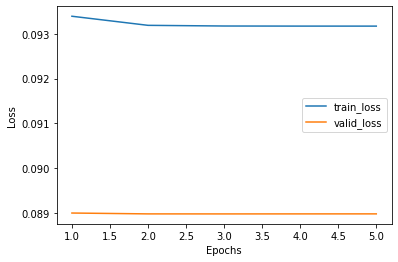

In [22]:
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [23]:
def plot_data(glm_zeta, net_zeta):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.scatter(indices, net_zeta, color='blue', label='Neural Net Zeta', s=10, alpha=0.5)
    ax.scatter(indices, glm_zeta, color='orange', label='GLM Zeta', s=10, alpha=0.5)
    
    ax.set_title('Neural Net vs GLM Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()
    
    plt.ylim(0.5, 1.3)

    plt.show()


In [24]:
tstdl = DataLoader(test_set, batch_size=64, num_workers=0, shuffle=False, pin_memory=True)

In [25]:
model.eval()

data_iter = iter(tstdl)

number of samples: 5


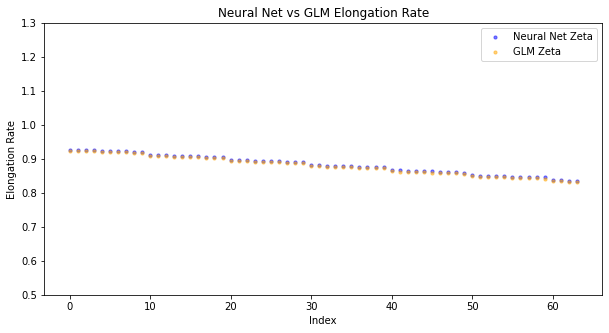

number of samples: 5


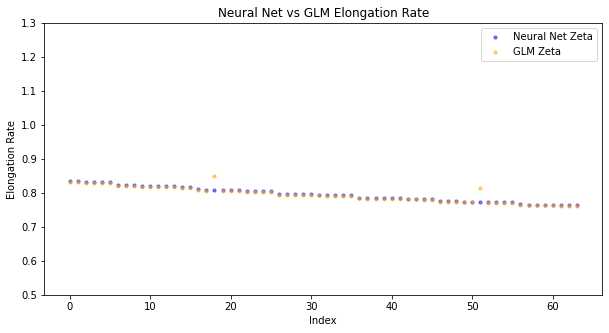

number of samples: 5


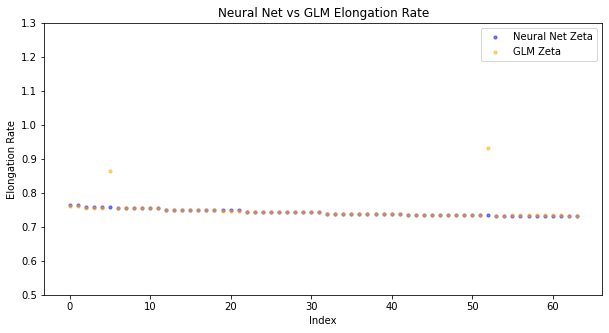

number of samples: 5


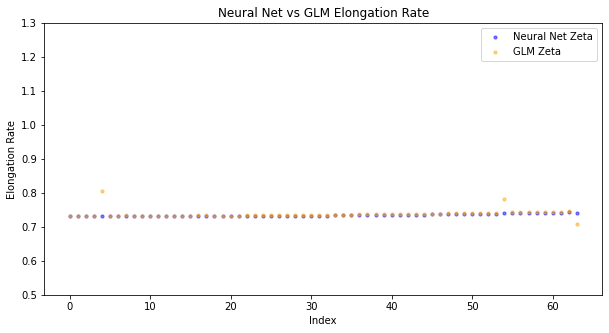

In [26]:
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        rho_ji = model(y_inputs)

    glm_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    net_zeta = torch.exp(rho_ji.cpu().squeeze())

    plot_data(glm_zeta, net_zeta)

In [27]:
net_zeta = []
glm_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        rho_ji = model(y_inputs)
        # convert log(Z) outputs to Z
        net_zeta.append(torch.exp(rho_ji.cpu()))
        glm_zeta.append(batch['Z_ji'])

net_zeta = torch.cat(net_zeta, dim=0)
glm_zeta = torch.cat(glm_zeta, dim=0)
mae = F.l1_loss(net_zeta.squeeze(), glm_zeta)
mse = F.mse_loss(net_zeta.squeeze(), glm_zeta)

correlation_coefficient = np.corrcoef(glm_zeta, net_zeta.squeeze())[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Correlation Coefficient: 0.9689399261531705
Mean Absolute Error: 0.0150
Mean Squared Error: 0.0011


In [28]:
def density_plot(glm_zeta, net_zeta, gene_id):
    sns.kdeplot(x=glm_zeta, y=net_zeta, fill=True, cmap="Blues")
            
    plt.xlim([0, max(glm_zeta)])
    plt.ylim([0, max(net_zeta)])


    plt.xlabel('GLM Elongation Rate')
    plt.ylabel('Neural Net Elongation Rate')
    plt.title(gene_id)
    plt.show()

In [29]:
def scatterplot(net_zeta, glm_zeta, gene_id, log_scale, zoom):
    indices = range(len(glm_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    min_val = min(min(net_zeta), min(glm_zeta))
    max_val = max(max(net_zeta), max(glm_zeta))

    if zoom:
        plt.xlim(0.75, 1.25)
        plt.ylim(0.75, 1.25)
    else:
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
    
    if log_scale:
        ax.scatter(np.log(net_zeta), np.log(glm_zeta), s=5)        
    else:
        ax.scatter(net_zeta, glm_zeta, s=5)
    
    ax.set_title(gene_id)
    ax.set_xlabel('Neural Net Zeta')
    ax.set_ylabel('GLM Zeta')
    ax.legend()

    plt.show()


In [30]:
def create_gene_id_mapping(dataset, indices):
    gene_id_map = {}
    for idx in indices:
        data = dataset[idx]
        gene_id = data['GeneId']

        if gene_id not in gene_id_map:
            gene_id_map[gene_id] = [idx]
        else:
            gene_id_map[gene_id].append(idx)

    return gene_id_map

test_dic = create_gene_id_mapping(dataset, test_idx)

number of samples: 12000


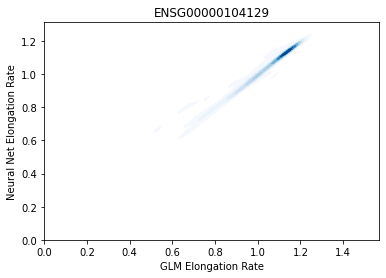

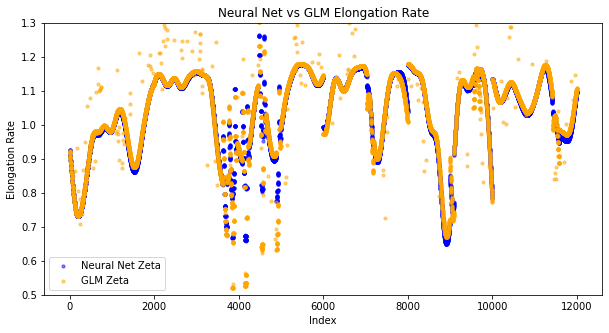

number of samples: 34000


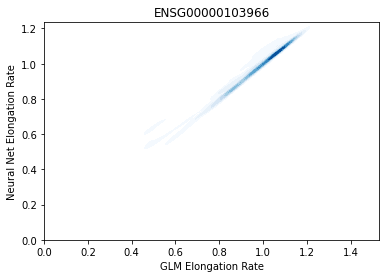

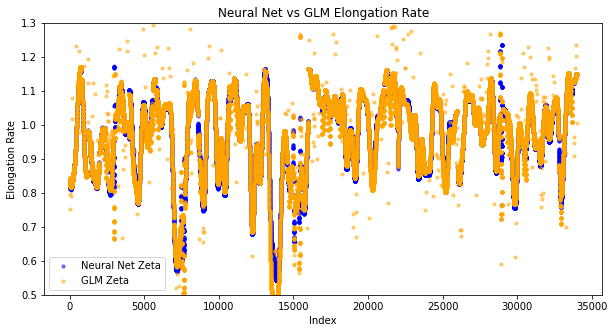

number of samples: 16000


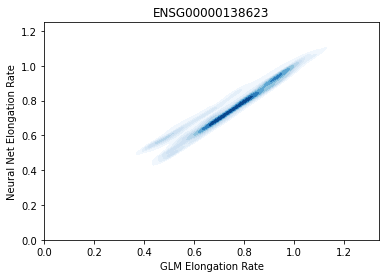

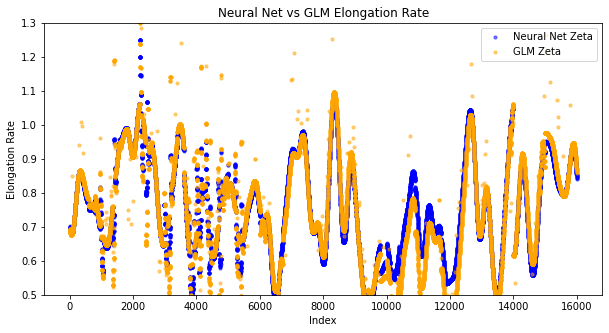

number of samples: 16000


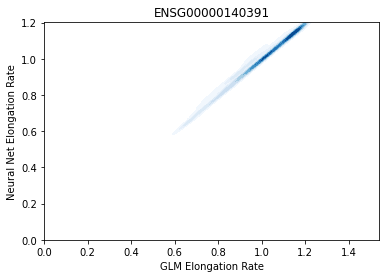

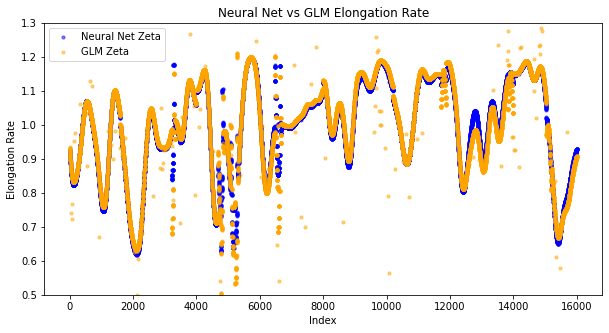

number of samples: 14000


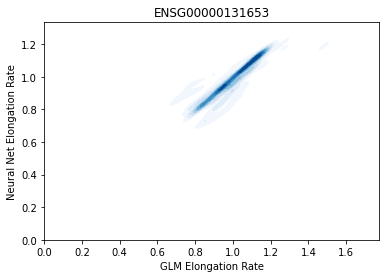

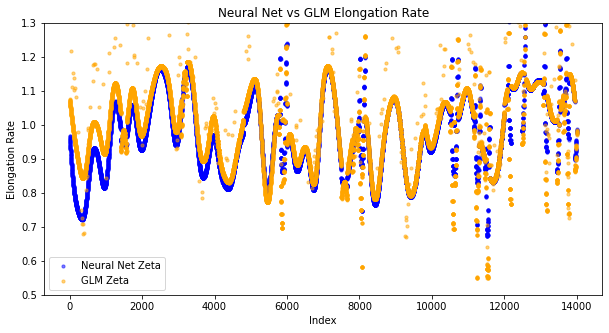

number of samples: 54000


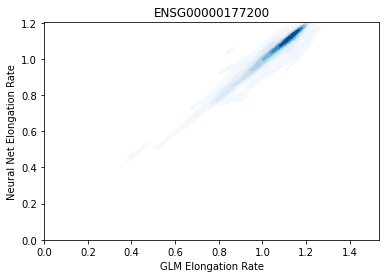

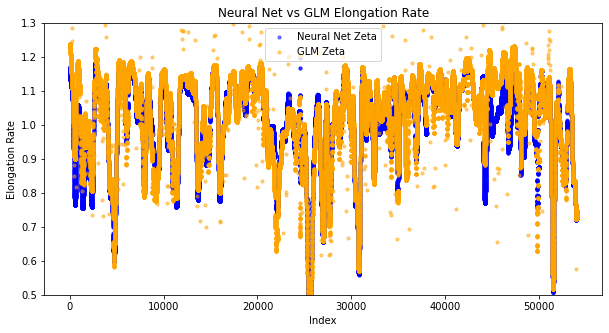

number of samples: 21710


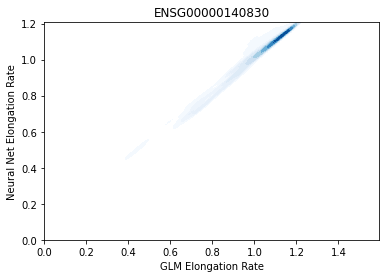

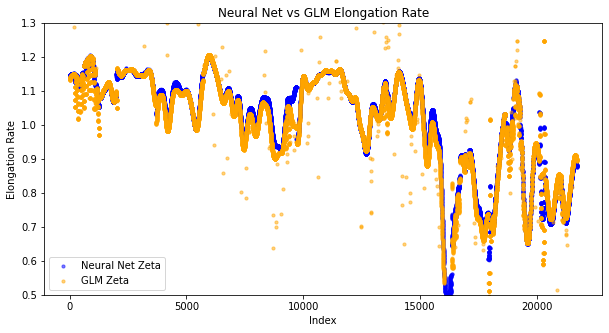

number of samples: 6000


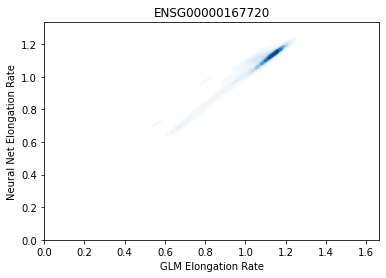

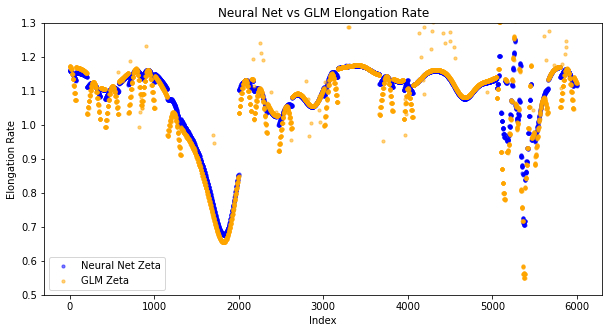

number of samples: 97144


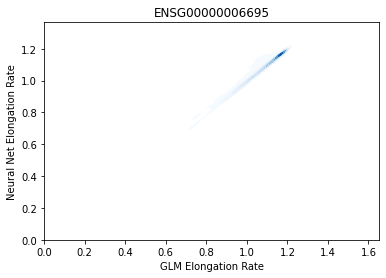

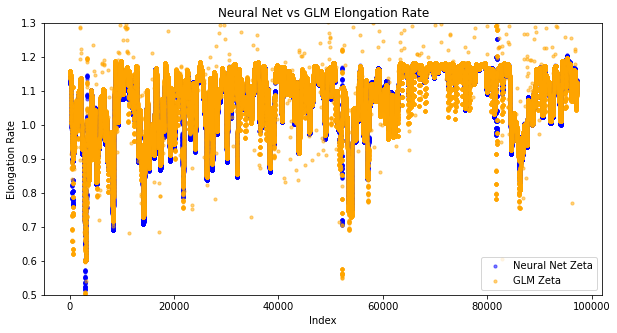

number of samples: 49956


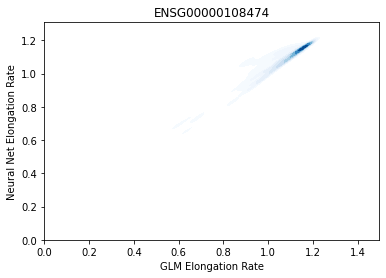

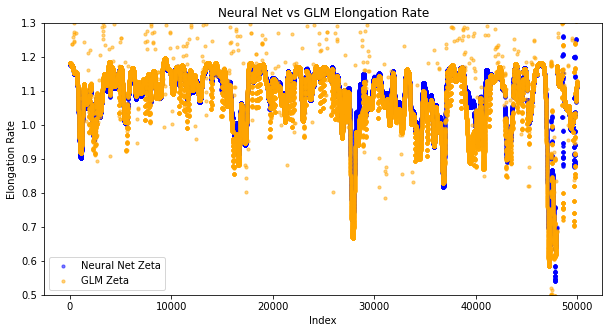

number of samples: 13522


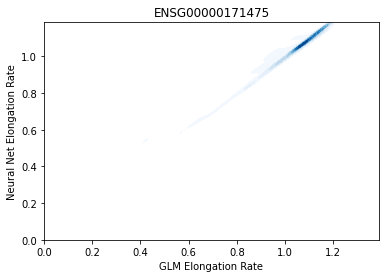

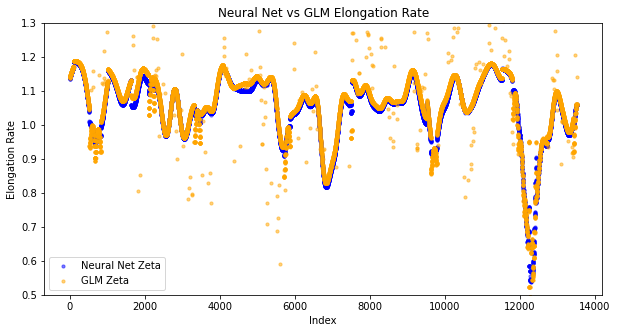

number of samples: 4000


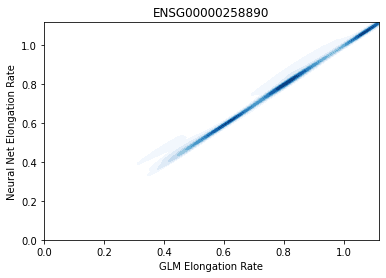

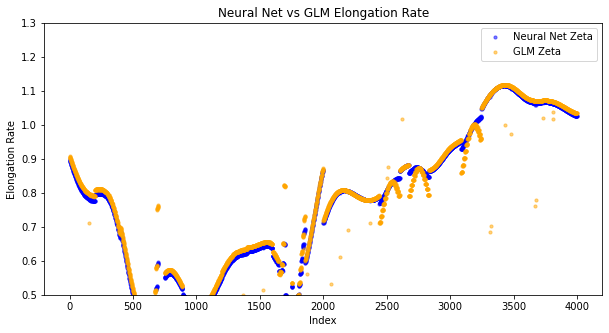

number of samples: 2000


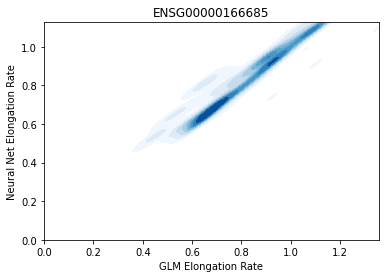

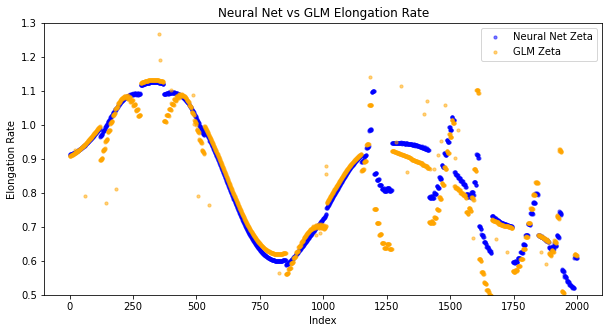

number of samples: 10000


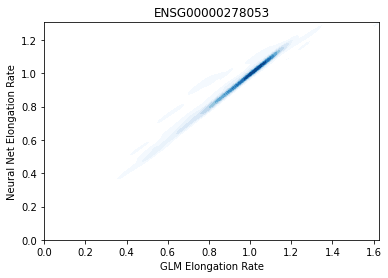

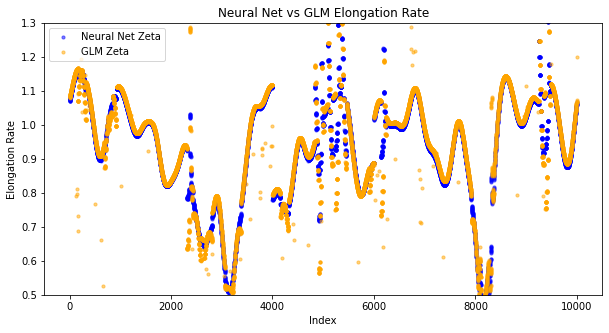

number of samples: 10000


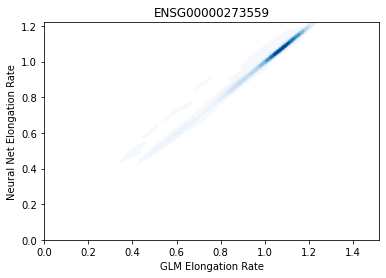

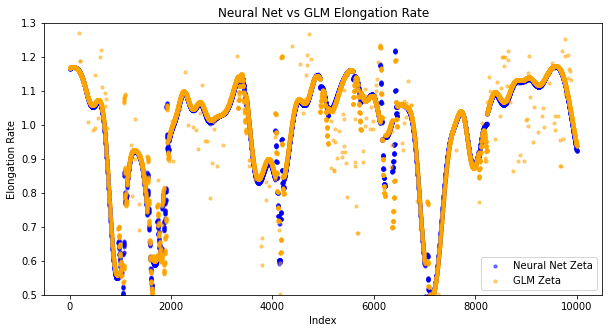

number of samples: 133966


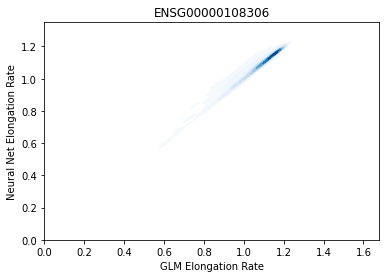

/grid/it/data/elzar/easybuild/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


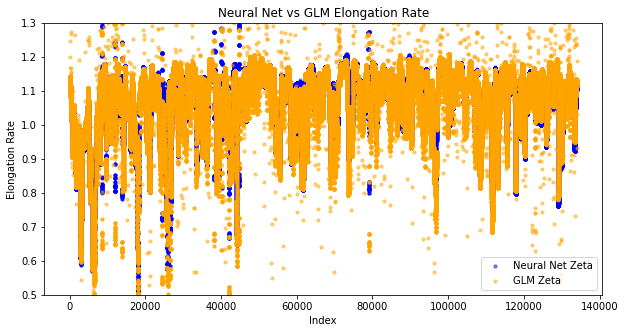

number of samples: 4000


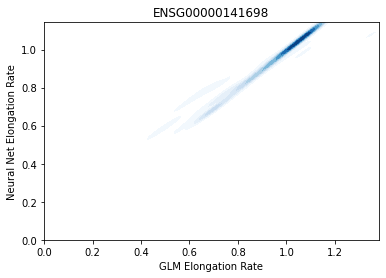

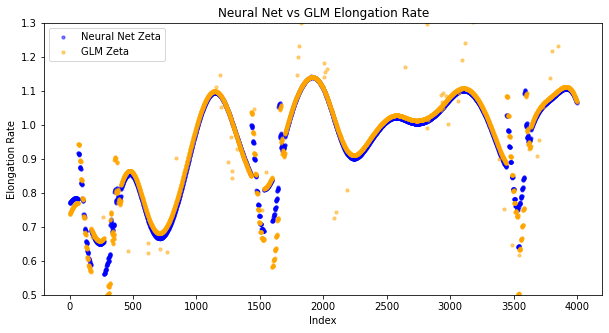

number of samples: 147909


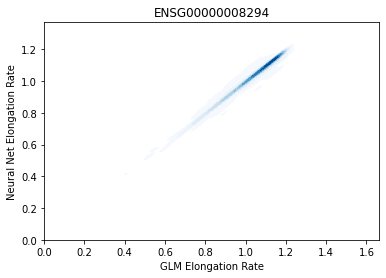

/grid/it/data/elzar/easybuild/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


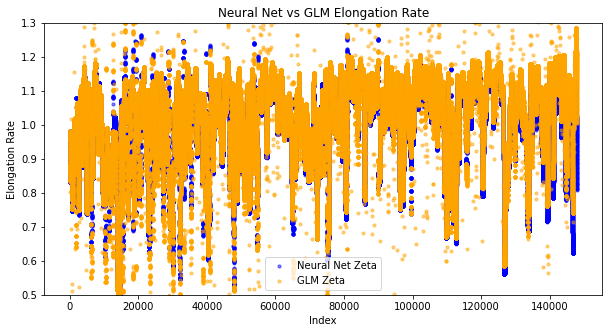

number of samples: 28000


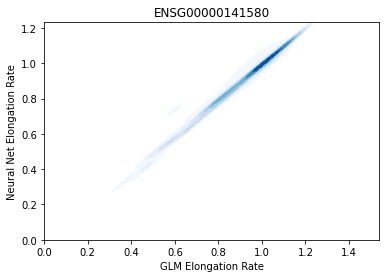

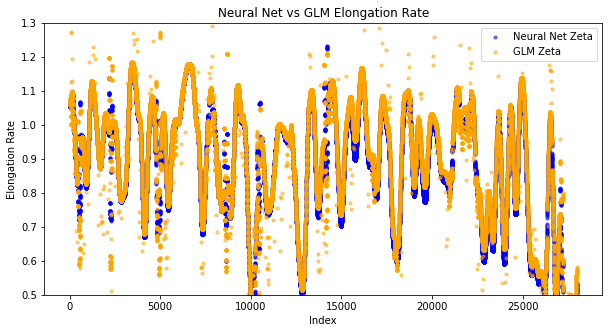

number of samples: 4000


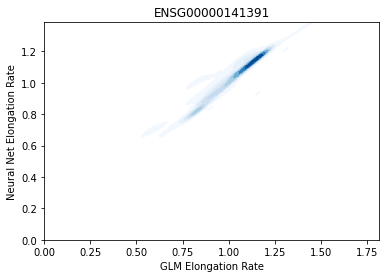

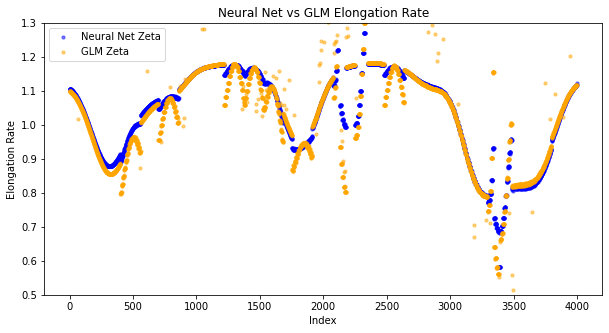

number of samples: 381241


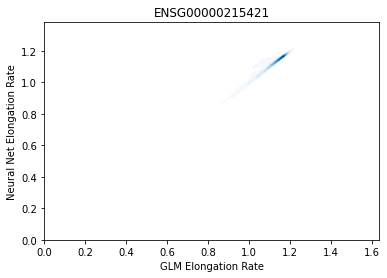

KeyboardInterrupt: 

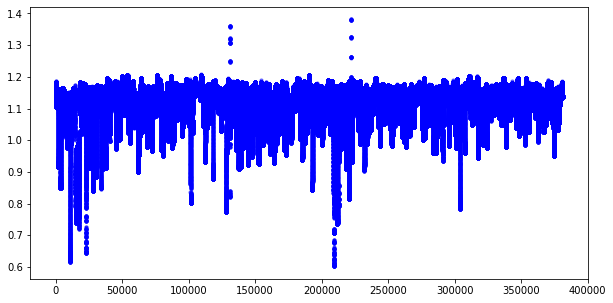

In [31]:
for gene_id, indices in test_dic.items():
    gene_id_subset = Subset(dataset, indices)
    test_loader = DataLoader(gene_id_subset, batch_size=len(indices))
    for batch in test_loader:
        model.eval()
        print("number of samples: " + str(len(indices)))

        with torch.no_grad():
            y_inputs = batch['Y_ji'].to(device)
            rho_ji = model(y_inputs)

        glm_zeta = batch['Z_ji']
        # convert log(Z) outputs to Z
        net_zeta = torch.exp(rho_ji.cpu().squeeze())
        
        density_plot(glm_zeta, net_zeta, gene_id)
        
        #scatterplot(predicted_zeta, simulated_zeta, gene_id, False, False)
        
        plot_data(glm_zeta, net_zeta)
        

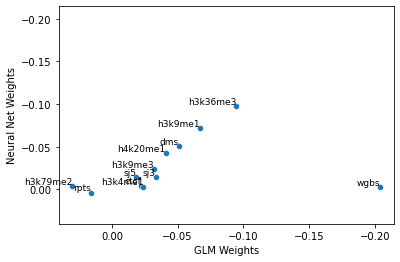

In [45]:
sns.scatterplot(x=glm_kappa, y=weights[0])

for i in range(len(glm_kappa)):
    plt.text(glm_kappa[i], weights[0][i], feature_names[i], fontsize=9, ha='right', va='bottom')
plt.xlabel('GLM Weights')
plt.ylabel('Neural Net Weights')

max_val = max(np.max(glm_kappa), np.max(weights[0])) + 0.01
min_val = min(np.min(glm_kappa), np.min(weights[0])) - 0.01

plt.xlim(max_val, min_val)
plt.ylim(max_val, min_val)

# Show the plot
plt.show()

In [ ]:
print(weights)